<a href="https://colab.research.google.com/github/sjoon0305/Simulation/blob/main/3. CB_DON with mode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 구글 코랩 GPU 설정법
- 상단에 런타임 - 런타임 유형 변경 - T4 GPU 선택 - 저장

# 2. DeepONet(w/o trunk net, 고유 모드로 대체) Training

In [ ]:
!wget https://github.com/sjoon0305/Simulation/raw/main/train_data_100.npz
!wget https://github.com/sjoon0305/Simulation/raw/main/vali_data_30.npz

In [1]:
# 학습 데이터 불러오기
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Polygon
import torch
import torch.nn as nn
from torch.utils.data import Dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def convert_np_to_tensor(array):
    if isinstance(array, np.ndarray):
        return torch.from_numpy(array).to(torch.float32)
    return array

def load_training_tensors(file_path):
    data = np.load(file_path)
    branch = convert_np_to_tensor(data['force_func'])
    trunk = convert_np_to_tensor(data['existing_corr'])
    output = convert_np_to_tensor(data['boundary_corr'])
    return branch, trunk, output

branch, trunk, output = load_training_tensors("train_data_100.npz")
branch_inputs = branch.to(device)
trunk_input = trunk.to(device)
deeponet_outputs = output.to(device)

print("Branch_inputs shape   :", branch_inputs.shape, branch_inputs.device)    # (677, 1, 81, 81)
print("Trunk_input shape    :", trunk_input.shape, trunk_input.device)     # (677, 121, 2)
print("Deeponet_outputs shape:", deeponet_outputs.shape, deeponet_outputs.device)     # (677, 121, 2)

Branch_inputs shape   : torch.Size([100, 81]) cuda:0
Trunk_input shape    : torch.Size([81, 1]) cuda:0
Deeponet_outputs shape: torch.Size([100, 81]) cuda:0


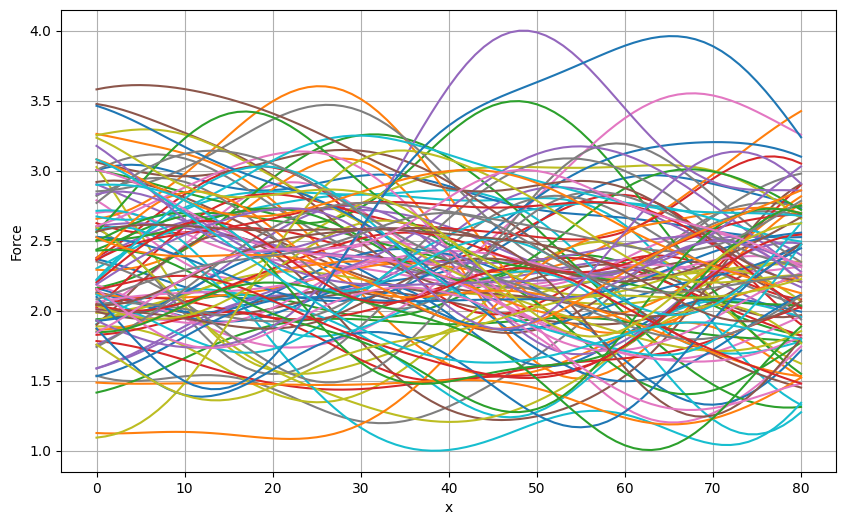

In [2]:
# Branch net의 입력 시각화 : 빔 위의 힘 분포 함수
plt.figure(figsize=(10, 6))
for i in range(branch_inputs.shape[0]):
    plt.plot(branch_inputs[i].cpu().detach().numpy().squeeze(), label=f'Branch Input {i}')

# 라벨 및 범례
plt.xlabel("x")
plt.ylabel("Force")
plt.grid(True)
plt.show()

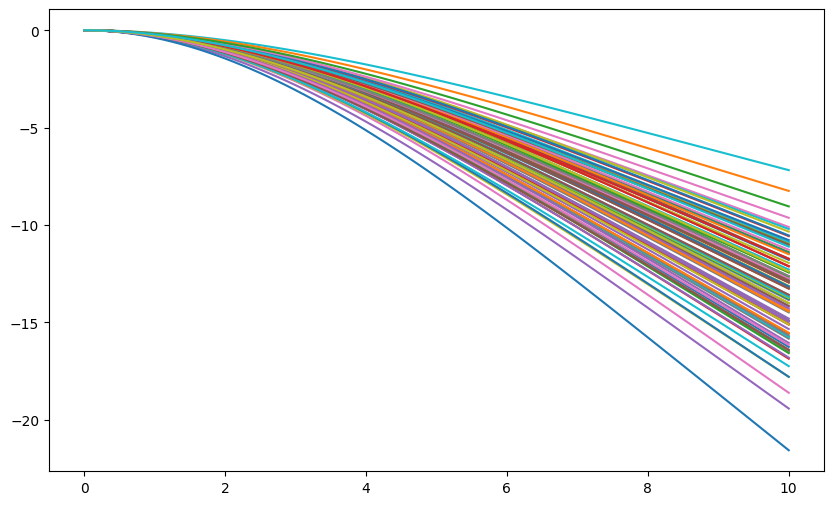

In [3]:
# FEM 해석 결과 시각화 : 빔의 변형 결과
plt.figure(figsize=(10, 6))
for i in range(deeponet_outputs.shape[0]):
    deeponet_plot = deeponet_outputs[i].cpu().detach().numpy().squeeze()
    plt.plot(np.linspace(0,10,81) , deeponet_plot, label=f'Branch Input {i}')

Text(0.5, 1.0, 'Deformation of Beam')

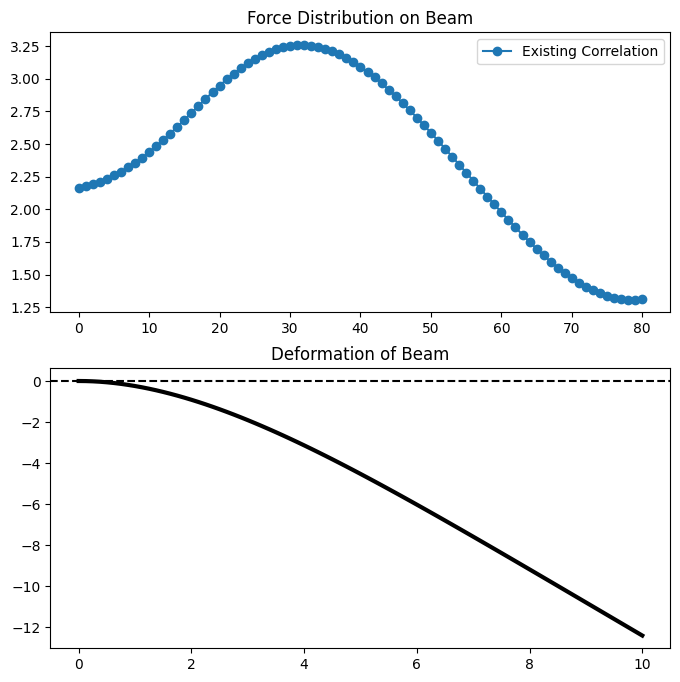

In [4]:
# 힘 분포에 따른 빔의 변형 시각화
import matplotlib.pyplot as plt
index_final = 32
branch_plot = branch_inputs[index_final].cpu().detach().numpy().squeeze()
deeponet_plot = deeponet_outputs[index_final].cpu().detach().numpy().squeeze()


fig, axes = plt.subplots(2, 1, figsize=(8, 8))
axes[0].plot(branch_plot,'-o', label="Existing Correlation")
axes[0].set_title("Force Distribution on Beam")
axes[0].legend()
axes[1].plot(np.linspace(0,10,81), deeponet_plot, color='k', linewidth = 3)
axes[1].axhline(y=0, color='k', linestyle='--')
axes[1].set_title("Deformation of Beam")

x shape: (81,)
U shape: (81, 12)


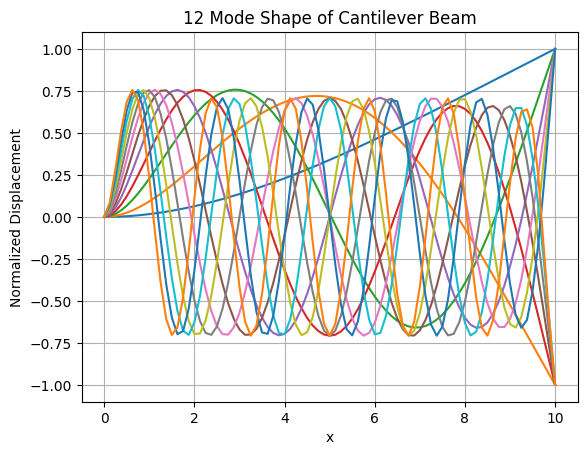

In [5]:
import numpy as np
import matplotlib.pyplot as plt

L = 10.0
x = np.linspace(0, L, 81)
# x = np.linspace(0, L, 400)
# 모드 고유값 (beta)
beta_values = np.array([
    1.87510407, 4.69409113, 7.85475744, 10.99554073, 14.13716839, 17.27875953,
    20.42035225, 23.56194490, 26.70353756, 29.84513021, 32.98672286, 36.12831551])

# 첫 모드의 베타
mode = 12
betaL = beta_values[mode-1]
beta = betaL / L

# 모드 형상 함수
def mode_shape(x, mode, L):
    betaL = beta_values[mode - 1]
    beta = betaL / L
    term1 = np.cosh(beta * x) - np.cos(beta * x)
    term2 = (np.cosh(beta * L) + np.cos(beta * L)) / (np.sinh(beta * L) + np.sin(beta * L))
    term3 = np.sinh(beta * x) - np.sin(beta * x)
    return term1 - term2 * term3

# 결과 저장 배열 (81 지점 x 10 모드)
size =  12
U = np.zeros((81, size))  # 각 열은 모드 번호, 각 행은 x 지점

# 계산 루프
for mode in range(1, size+1):  # 1~10 모드
    u_n = mode_shape(x, mode, L)
    U[:, mode - 1] = u_n  # 각 열에 저장

# 결과: x (81,), U (81, 10)
print("x shape:", x.shape)       # (81,)
print("U shape:", U.shape)       # (81, 10)

plt.plot(x, U / np.max(np.abs(U)))  # 정규화된 모드 형상
plt.title(f"{mode} Mode Shape of Cantilever Beam")
plt.xlabel("x")
plt.ylabel("Normalized Displacement")
plt.grid(True)
plt.show()


In [6]:
class Network(torch.nn.Module):
  def __init__(self):
    super(Network,self).__init__()
    self.bias  = nn.Parameter(torch.tensor(1.0), requires_grad=True)
    self.branch = nn.Sequential(
      nn.Linear(81, 50), nn.ReLU(),  # 30: sensor 차원
      nn.Linear(50, 50), nn.ReLU(),
      nn.Linear(50, 24), nn.ReLU()   # 80: branch net의 차원 
    )

  def forward(self, u, y):
    branch_out = self.branch(u) # (batch_size, 24)
    trunk_out  = y # self.trunk(y)
    out = branch_out @ trunk_out.t()
    return out, trunk_out

def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.xavier_normal_(m.weight.data)
    nn.init.zeros_(m.bias)

model = Network()
model = model.to(device)
model.apply(init_weights)

# 손실 함수 및 옵티마이저
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


In [7]:
U_tensor = convert_np_to_tensor(U)         
U_neg = -U_tensor                                      
mode_u = torch.cat([U_tensor, U_neg], dim=1).to(device)
mode_u.requires_grad_(True)

n_epochs = 20000
for epoch in range(n_epochs):
            
    optimizer.zero_grad()

    #forward pass through model#
    pred, _= model(branch_inputs, mode_u)
    
    loss = loss_fn(pred, deeponet_outputs)

    # Backward pass
    loss.backward()
    optimizer.step()

    
    if epoch % 1000 ==0:
        print(f'Epoch: {epoch}, Loss: {float(loss):.3}')

print(f'Epoch: {epoch+1}, Final Loss: {float(loss):.3}')


Epoch: 0, Loss: 1.07e+02
Epoch: 1000, Loss: 0.00282
Epoch: 2000, Loss: 0.000656
Epoch: 3000, Loss: 0.000294
Epoch: 4000, Loss: 0.000154
Epoch: 5000, Loss: 9.55e-05
Epoch: 6000, Loss: 7.59e-05
Epoch: 7000, Loss: 6.92e-05
Epoch: 8000, Loss: 6.68e-05
Epoch: 9000, Loss: 0.000799
Epoch: 10000, Loss: 7.3e-05
Epoch: 11000, Loss: 6.31e-05
Epoch: 12000, Loss: 6.22e-05
Epoch: 13000, Loss: 0.000121
Epoch: 14000, Loss: 0.000947
Epoch: 15000, Loss: 6.14e-05
Epoch: 16000, Loss: 6.82e-05
Epoch: 17000, Loss: 6.23e-05
Epoch: 18000, Loss: 0.000155
Epoch: 19000, Loss: 7.79e-05
Epoch: 20000, Final Loss: 0.000146


In [8]:
_, trunk_output = model(branch_inputs, mode_u)
print("trunk output shape:", trunk_output.shape)

trunk output shape: torch.Size([81, 24])


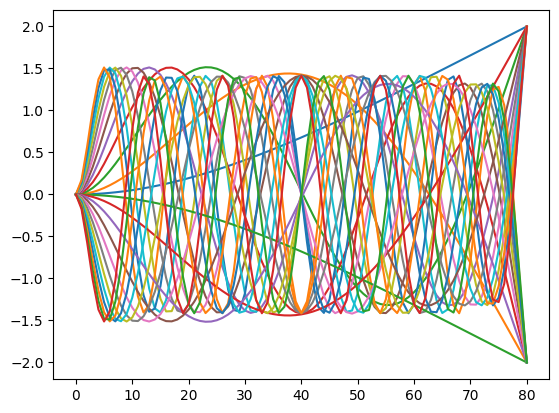

In [ ]:
# 모델의 트렁크 output 시각화
trunk_output_plot= trunk_output.detach().cpu().numpy()
for i in range(trunk_output_plot.shape[1]):
    plt.plot(trunk_output_plot[:,i], label=f'Trunk Output {i}')
    # plt.legend()

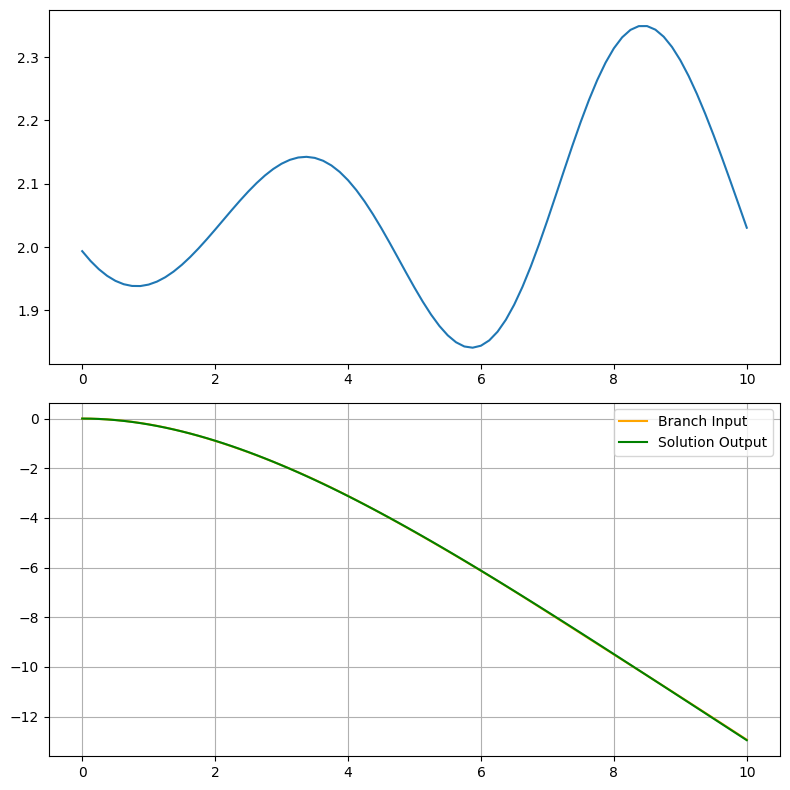

In [10]:
# 학습 데이터 검증
index_test = 25
output_pred_np, _ = model(branch_inputs, mode_u)
output_pred_np = output_pred_np[index_test].cpu().detach().numpy()
branch_plot = branch_inputs[index_test].detach().cpu().numpy().squeeze()
solution_plot = deeponet_outputs[index_test].detach().cpu().numpy().squeeze()

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
axes[0].plot(np.linspace(0,10,81), branch_plot, label='Branch Input')


axes[1].plot(np.linspace(0,10,81), output_pred_np ,color = 'orange', label='Branch Input')
axes[1].plot(np.linspace(0,10,81), solution_plot ,color = 'green', label='Solution Output')
axes[1].legend()
axes[1].grid(True)
# 그래프 표시
plt.tight_layout()
plt.show()

# 3. DeepONet(w/o trunk net, 고유 모드로 대체) Validation

In [11]:
# Validation 데이터 불러오기
def load_training_tensors(file_path):
    data = np.load(file_path)
    branch = convert_np_to_tensor(data['force_func'])
    trunk = convert_np_to_tensor(data['existing_corr'])
    output = convert_np_to_tensor(data['boundary_corr'])
    return branch, trunk, output

branch, trunk, output = load_training_tensors("vali_data_30.npz")
vali_branch_inputs = branch.to(device)
vali_trunk_input = trunk[0].to(device)
vali_deeponet_outputs = output.to(device)

print("vali branch_inputs shape   :", vali_branch_inputs.shape, vali_branch_inputs.device)    # (677, 1, 81, 81)
print("vali trunk_input shape    :", vali_trunk_input.shape, vali_trunk_input.device)     # (677, 121, 2)
print("vali deeponet_outputs shape:", vali_deeponet_outputs.shape, vali_deeponet_outputs.device)     # (677, 121, 2)

vali branch_inputs shape   : torch.Size([30, 81]) cuda:0
vali trunk_input shape    : torch.Size([1]) cuda:0
vali deeponet_outputs shape: torch.Size([30, 81]) cuda:0


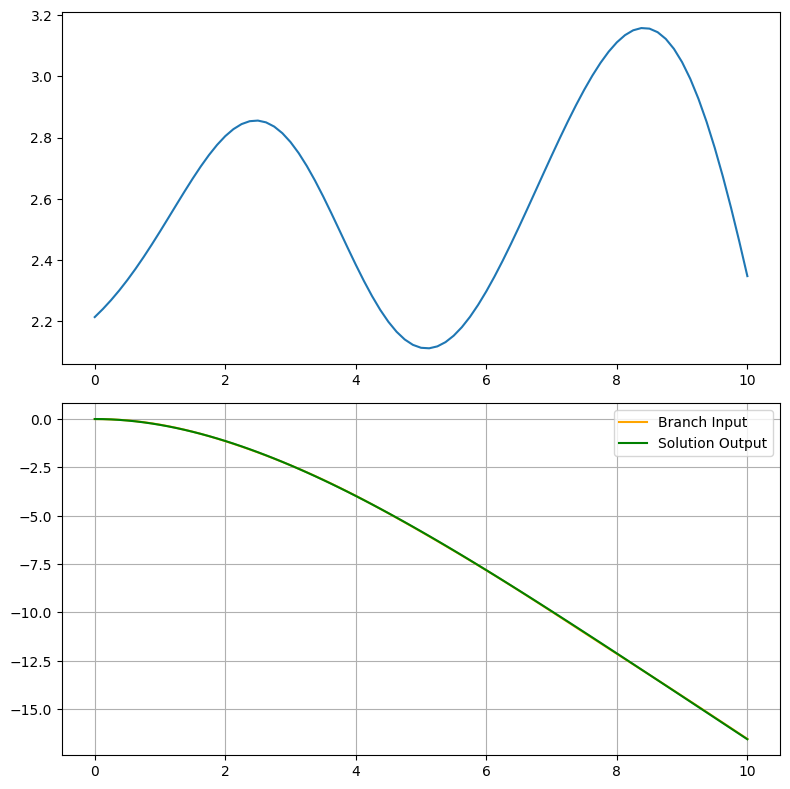

In [12]:
# 학습 데이터 검증
index_test = 21
output_pred, _ = model(vali_branch_inputs, mode_u)
output_pred_np = output_pred[index_test].cpu().detach().numpy()
branch_plot = vali_branch_inputs[index_test].detach().cpu().numpy().squeeze()
solution_plot = vali_deeponet_outputs[index_test].detach().cpu().numpy().squeeze()

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
axes[0].plot(np.linspace(0,10,81), branch_plot, label='Branch Input')


axes[1].plot(np.linspace(0,10,81), output_pred_np ,color = 'orange', label='Branch Input')
axes[1].plot(np.linspace(0,10,81), solution_plot ,color = 'green', label='Solution Output')
axes[1].legend()
axes[1].grid(True)
# 그래프 표시
plt.tight_layout()
plt.show()